In [1]:
import os, sys
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import fitsio
from astropy.table import Table

# Inspect a single tracer catalog

What is inside a typical galaxy DESI catalog?

In [2]:
path_to_catalogs = '/n/netscratch/eisenstein_lab/Lab/cristhian/DESI/dr1_catalogs/'
desi_catalog = path_to_catalogs+'BGS_BRIGHT-21.5_NGC_clustering.dat.fits'
t = Table.read(desi_catalog, hdu=1)
t

TARGETID,Z,NTILE,RA,DEC,PHOTSYS,FRAC_TLOBS_TILES,WEIGHT_ZFAIL,WEIGHT_SYS,WEIGHT,WEIGHT_COMP,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,NX,WEIGHT_FKP
,,,deg,deg,,,,,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,,
int64,float64,int64,float64,float64,bytes1,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64
39627546848921980,0.33305719416593743,1,159.09470622413318,-9.958732755162625,S,0.946034341782502,1.000040054321289,0.9964131712913513,1.519623329597879,3.0,13.01257,56.88178,123.55741,177.8957,124.03348,0.00023726913865040986,0.3758149588883515
39627546886671368,0.17802081340026568,1,161.46174512453442,-9.939605064869692,S,0.9142244460328807,1.0,0.9845421314239502,0.5004862476695985,1.0,117.666374,252.32066,435.4904,76.45175,32.830444,0.0002791750577819587,0.3384982061577485
39627546890865176,0.23150193477889233,1,161.61797161786833,-9.976235919688158,S,0.9142244460328807,1.0,0.9845421314239502,2.001944990678394,4.0,27.79351,98.50113,199.17336,214.64444,153.80284,0.00025261982980926177,0.3612274613461418
39627546907639884,0.30935922992481724,1,162.51342732550847,-9.957208510132505,S,0.9142244460328807,1.0,0.9948785305023193,1.0114813916556327,2.0,10.489419,46.804855,101.30671,142.58342,99.156265,0.00022497000981145903,0.3883811780090407
39627547524203428,0.19122496212186635,1,199.8477984869264,-9.946590156725586,S,0.9177652228499686,1.0,0.9892548322677612,0.502881921644766,1.0,56.87328,159.86404,307.3073,143.52632,-11.803656,0.0002547850077456912,0.35926056289698755
39627547524204283,0.27500477911528753,1,199.90825395312305,-9.944834047563031,S,0.9177652228499686,1.0,0.9892548322677612,1.508645764934298,3.0,12.190971,48.391426,97.81825,123.34444,84.81733,0.00024891330566877514,0.36464501953799605
39627547532592796,0.241556909301566,2,200.41207531706496,-9.921983079982894,S,0.9977358490566037,1.0,0.9911619424819946,2.1590128589079653,3.0,27.122175,96.387085,193.53957,229.16992,162.64662,0.00037140329698582403,0.2777914297680866
39627547549369094,0.3265140095423266,1,201.3457488354929,-9.9494730156248,S,0.922299095263438,1.0,0.9909157156944275,0.5037262220433956,1.0,9.053813,37.286068,80.74898,119.41689,82.00957,0.0002304173178974355,0.38271341298934736


Let's now plot the galaxies

In [3]:
ra_list, dec_list = [], []

t = Table.read(desi_catalog, hdu=1)
ra = np.asarray(t['RA'], dtype=float)
dec = np.asarray(t['DEC'], dtype=float)
print(ra.shape, dec.shape)

(217614,) (217614,)


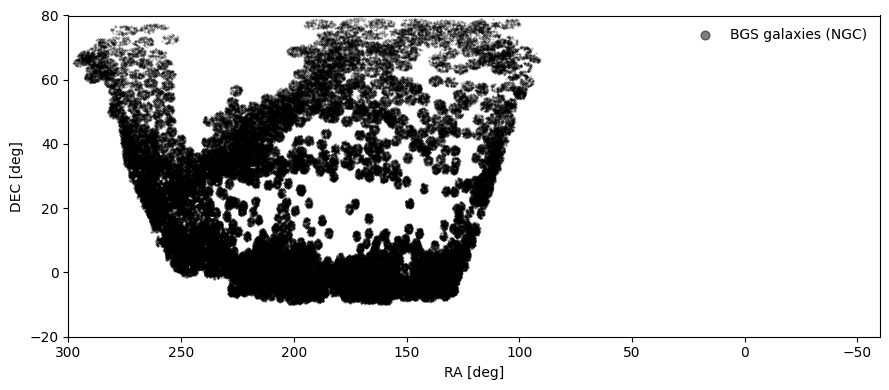

In [4]:
plt.figure(figsize=(9,4))
plt.scatter(ra,   dec,   s=0.1, c='k', alpha=0.5, label='BGS galaxies (NGC)')

plt.xlim(300, -60)          # same RA wrap as you used
plt.ylim(-20, 80)           # tweak if you want tighter bounds
plt.xlabel('RA [deg]'); plt.ylabel('DEC [deg]')
plt.legend(markerscale=20, frameon=False)
plt.tight_layout()
plt.show()

We should concatenate the catalogs (SGC+NGC)

In [5]:
ra_list, dec_list = [], []
catalog_names = ['BGS_BRIGHT-21.5_SGC_clustering.dat.fits', 'BGS_BRIGHT-21.5_NGC_clustering.dat.fits']

for catalog_name in catalog_names:
    t = Table.read(path_to_catalogs + catalog_name, hdu=1)
    ra = np.asarray(t['RA'], dtype=float)
    dec = np.asarray(t['DEC'], dtype=float)
    ra[ra > 300] -= 360.0

    ra_list.append(ra)
    dec_list.append(dec)

# concatenate into single numpy arrays
ra  = np.concatenate(ra_list) if ra_list else np.array([], dtype=float)
dec = np.concatenate(dec_list) if dec_list else np.array([], dtype=float)

print(ra.shape, dec.shape)

(300043,) (300043,)


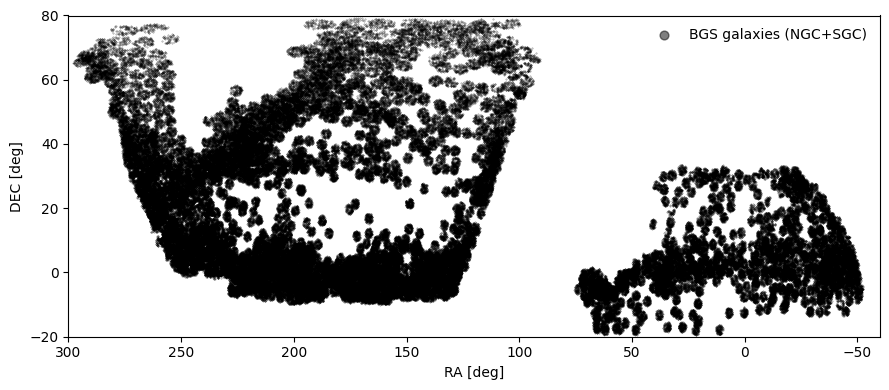

In [6]:
plt.figure(figsize=(9,4))
plt.scatter(ra,   dec,   s=0.1, c='k', alpha=0.5, label='BGS galaxies (NGC+SGC)')

plt.xlim(300, -60)          # same RA wrap as you used
plt.ylim(-20, 80)           # tweak if you want tighter bounds
plt.xlabel('RA [deg]'); plt.ylabel('DEC [deg]')
plt.legend(markerscale=20, frameon=False)
plt.tight_layout()
plt.show()

Redshift distributions

In [7]:
def read_concatenated_catalogs(catalog_names, base_path, column, dtype=float):
    """
    Read a single column from multiple DESI FITS catalogs and concatenate.

    Parameters
    ----------
    catalog_names : list of str
        Filenames (e.g., ['BGS_BRIGHT_SGC_clustering.dat.fits', '...NGC...']).
    base_path : str
        Directory where the catalogs live.
    column : str
        Column name to read (e.g., 'Z', 'RA', 'DEC', 'WEIGHT_FKP').
    dtype : type, optional
        Cast the result to this dtype (default: float).

    Returns
    -------
    arr : np.ndarray
        Concatenated array of the requested column.
    """
    out = []
    for name in catalog_names:
        path = os.path.join(base_path, name)
        # read only the requested column to save memory
        t = Table.read(path, hdu=1)
        arr = np.asarray(t[column], dtype=dtype)
        out.append(arr)

    if not out:
        return np.array([], dtype=dtype)

    arr = np.concatenate(out)
    return arr

z = read_concatenated_catalogs(['BGS_BRIGHT-21.5_SGC_clustering.dat.fits', 'BGS_BRIGHT-21.5_NGC_clustering.dat.fits'], path_to_catalogs, "Z", dtype=float)

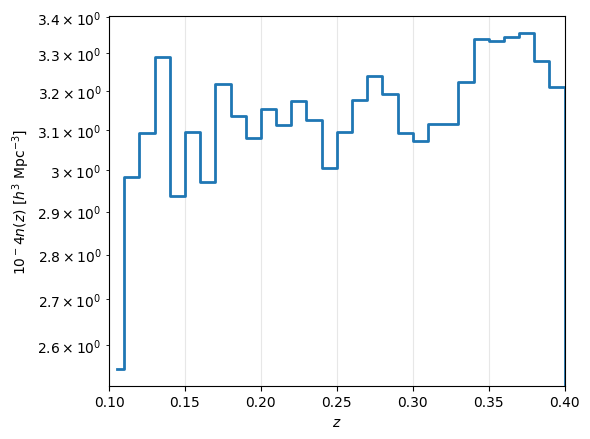

In [8]:
# --- inputs ---
z                  # your galaxy redshifts
dz = 0.01                          # bin width
zmin, zmax = 0.1, 0.4

# --- cosmology (DESI fiducial) ---
from cosmoprimo.fiducial import DESI
distance = DESI(engine='class').comoving_radial_distance   # returns comoving distance [Mpc/h]

# --- helper: shell volume between z1,z2 for a given area ---
def volume(z1, z2, sky_area):
    zrange = np.array([z1, z2])
    disl = distance(zrange)
    vshell = 4/3.*np.pi*(disl[1]**3.-disl[0]**3.) #area of a shell
    sel = z > zrange[0] # select redshift bin z>zmin 
    sel &= z < zrange[1] # select redshift bin z>zmax
    fsky = sky_area/41253 # solid angle for sky fraction
    vtot = vshell*fsky
    return vtot

# --- bins and counts ---
edges = np.arange(zmin, zmax + dz, dz)
centers = 0.5*(edges[1:] + edges[:-1])
counts, _ = np.histogram(z, bins=edges) 

# --- volumes and n(z) on the fine grid ---
vols = np.array([volume(edges[i], edges[i+1], 7473) for i in range(len(edges)-1)])
nz   = (counts / vols) * 1e4           # [h^3 Mpc^-3]

# --- plot ---
fig, ax = plt.subplots(figsize=(6,4.5))
ax.step(centers, nz, where='mid', lw=2, label='sample')
ax.set_yscale('log')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$10^-4 n(z)\ [h^{3}\ \mathrm{Mpc}^{-3}]$')
ax.grid(alpha=0.3)
ax.set_xlim(0.1,0.4)

plt.tight_layout()
plt.show()

Magnitude cut for BGS

In [9]:
#The BGS selection in DESI (for the cosmology sample) uses an SDSS-calibrated k-corrected absolute magnitude in the SDSS r-band, called ABSMAG01_SDSS_R in the catalog.
mag_r_sdss = read_concatenated_catalogs(['BGS_BRIGHT-21.5_full_HPmapcut.dat.fits'], path_to_catalogs, "ABSMAG01_SDSS_R", dtype=float)
z_sdss = read_concatenated_catalogs(['BGS_BRIGHT-21.5_full_HPmapcut.dat.fits'], path_to_catalogs, "Z_not4clus", dtype=float)

(-17.0, -23.0)

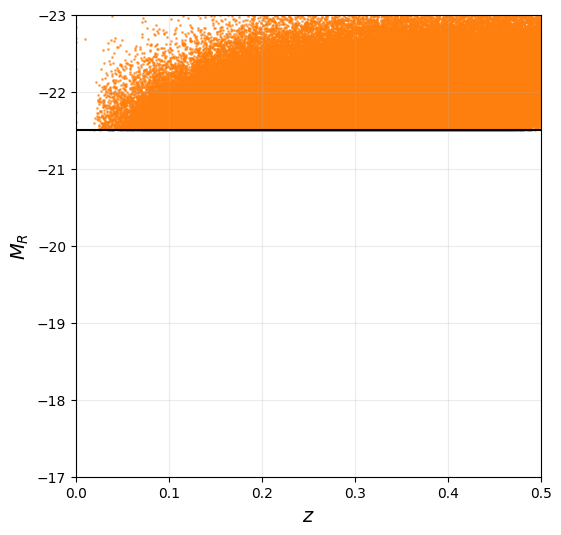

In [10]:
fig, ax = plt.subplots(figsize=(6,6))

# points
M_r_sdss = mag_r_sdss + 0.97*z_sdss -0.095
ax.scatter(z_sdss, M_r_sdss, s=1, c='tab:orange', alpha=0.6, rasterized=True)
ax.axhline(-21.5, color='k')

# axes styling
ax.set_xlabel(r'$z$', fontsize=14)
ax.set_ylabel(r'$M_R$', fontsize=14)
ax.grid(True, alpha=0.25)
ax.invert_yaxis()                # magnitudes: more negative = brighter (goes "up")

# optional limits similar to the example
ax.set_xlim(0.0, 0.5)
ax.set_ylim(-17.0, -23.0)

# Let's get all the catalogs

In [11]:
path_to_catalogs = '/n/netscratch/eisenstein_lab/Lab/cristhian/DESI/dr1_catalogs/'
catalog_names = {'BGS': ['BGS_BRIGHT-21.5_SGC_clustering.dat.fits', 'BGS_BRIGHT-21.5_NGC_clustering.dat.fits'],
                 'LRG': ['LRG_SGC_clustering.dat.fits', 'LRG_NGC_clustering.dat.fits'],
                 'LRG+ELG': ['LRG+ELG_LOPnotqso_SGC_clustering.dat.fits', 'LRG+ELG_LOPnotqso_NGC_clustering.dat.fits'],
                 'ELG': ['ELG_LOPnotqso_SGC_clustering.dat.fits', 'ELG_LOPnotqso_NGC_clustering.dat.fits'],
                 'QSO': ['QSO_SGC_clustering.dat.fits', 'QSO_NGC_clustering.dat.fits'],
}

sky_area = {'BGS': 7473, 'LRG': 5840, 'LRG+ELG': 5914, 'ELG': 5914, 'QSO': 7249}

read_concatenated_catalogs(catalog_names=catalog_names['BGS'], base_path=path_to_catalogs, column="Z")

array([0.25220979, 0.37635243, 0.2530706 , ..., 0.35957538, 0.36054991,
       0.35935823])

In [12]:
z = {}
z['BGS'] = read_concatenated_catalogs(catalog_names=catalog_names['BGS'], base_path=path_to_catalogs, column="Z")
z['LRG'] = read_concatenated_catalogs(catalog_names=catalog_names['LRG'], base_path=path_to_catalogs, column="Z")
z['LRG+ELG'] = read_concatenated_catalogs(catalog_names=catalog_names['LRG+ELG'], base_path=path_to_catalogs, column="Z")
z['ELG'] = read_concatenated_catalogs(catalog_names=catalog_names['ELG'], base_path=path_to_catalogs, column="Z")
z['QSO'] = read_concatenated_catalogs(catalog_names=catalog_names['QSO'], base_path=path_to_catalogs, column="Z")

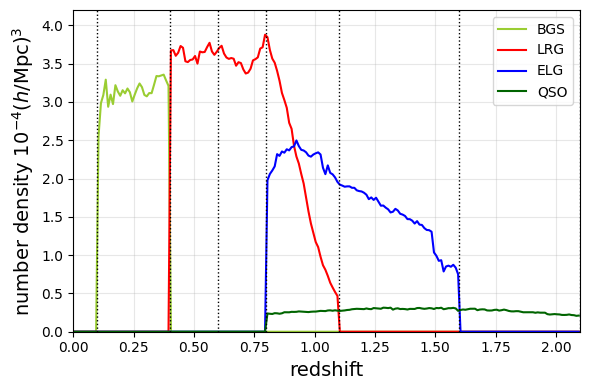

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from cosmoprimo.fiducial import DESI

# --- Inputs ---
colors = {
    'BGS': 'yellowgreen',
    'LRG': 'red',
    'ELG': 'blue',
    'QSO': 'darkgreen',
}

# Assume you've already run:
# z['BGS'], z['LRG'], z['ELG'], z['QSO'] = ... from read_concatenated_catalogs

distance = DESI(engine='class').comoving_radial_distance

def volume(z1, z2, sky_area):
    disl = distance([z1, z2])
    vshell = 4/3. * np.pi * (disl[1]**3 - disl[0]**3)
    fsky = sky_area / 41253.
    return vshell * fsky

# Define binning
dz = 0.01
edges = np.arange(0.0, 2.1 + dz, dz)
centers = 0.5 * (edges[1:] + edges[:-1])

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,4))

for tracer in ['BGS', 'LRG', 'ELG', 'QSO']:
    zvals = z[tracer]
    counts, _ = np.histogram(zvals, bins=edges)
    vols = np.array([volume(edges[i], edges[i+1], sky_area[tracer]) for i in range(len(edges)-1)])
    nz = (counts / vols) * 1e4  # [10^-4 h^3 Mpc^-3]
    
    ax.plot(centers, nz, label=tracer, color=colors[tracer])

# Add vertical lines at typical bin splits
for zline in [0.1, 0.4, 0.6, 0.8, 1.1, 1.6, 2.1]:
    ax.axvline(zline, color='k', ls=':', lw=1)

ax.set_xlabel("redshift", fontsize=14)
ax.set_ylabel(r"number density $10^{-4}(h/\mathrm{Mpc})^3$", fontsize=14)
ax.set_xlim(0.0, 2.1)
ax.set_ylim(0, 4.2)
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

Effective volume

In [15]:
def calc_veff_int_full(z,zrange,P0,fsky=1,h=.676,dz=.01,Nfac=1):
    fullsky = 360*360/np.pi
    zcut = zrange[0]
    veff = 0
    while zcut < zrange[1]:
        print(zcut)
        sel = z > zcut
        sel &= z < zcut+dz
        ngal = len(z[sel])*Nfac
        if fsky > 1:
            fsky = 1
        disl = distance([zcut,zcut+dz])
        vshell = 4/3.*np.pi*(disl[1]**3.-disl[0]**3.)

        vtot = vshell*fsky
        nbar = ngal/vtot
        veff += ((nbar*P0)/(1+nbar*P0))**2.*vtot
        zcut += dz
    return fsky*fullsky,veff/h**3./1e9,nbar


In [16]:
import numpy as np
from cosmoprimo.fiducial import DESI
import pandas as pd

# --- DESI setup ---
cosmo = DESI(engine='class')
distance = cosmo.comoving_radial_distance
h = cosmo.h

# --- Sky area per parent tracer (deg²) ---
sky_area = {'BGS': 7473, 'LRG': 5840, 'ELG': 5914, 'QSO': 7249}
fullsky = 360 * 360 / np.pi

# --- Fixed zeff values from DESI DR1 table ---
zeff_table = {
    'BGS': 0.30,
    'LRG1': 0.51,
    'LRG2': 0.71,
    'LRG3': 0.92,
    'ELG1': 0.95,
    'LRG3+ELG1': 0.93,
    'ELG2': 1.32,
    'QSO': 1.49,
}

# --- Veff calculator ---
def calc_veff_int_full(z, zrange, P0, fsky=1, h=0.676, dz=0.01, Nfac=1):
    zcut = zrange[0]
    veff = 0
    while zcut < zrange[1]:
        sel = (z > zcut) & (z < zcut + dz)
        ngal = len(z[sel]) * Nfac
        disl = distance([zcut, zcut + dz])
        vshell = 4/3. * np.pi * (disl[1]**3 - disl[0]**3)
        vtot = vshell * fsky
        nbar = ngal / vtot if vtot > 0 else 0
        veff += ((nbar * P0) / (1 + nbar * P0))**2 * vtot if vtot > 0 else 0
        zcut += dz
    return fsky * fullsky, veff / h**3 / 1e9, nbar

# --- Tracer configurations ---
# note: 'tracer_key' corresponds to the parent z array to use (BGS, LRG, etc.)
configs = [
    {'name': 'BGS',           'zrange': [0.1, 0.4], 'P0': 9200, 'tracer_key': 'BGS'},
    {'name': 'LRG1',          'zrange': [0.4, 0.6], 'P0': 8900, 'tracer_key': 'LRG'},
    {'name': 'LRG2',          'zrange': [0.6, 0.8], 'P0': 8900, 'tracer_key': 'LRG'},
    {'name': 'LRG3',          'zrange': [0.8, 1.1], 'P0': 8400, 'tracer_key': 'LRG'},
    {'name': 'ELG2',          'zrange': [1.1, 1.6], 'P0': 2900, 'tracer_key': 'ELG'},
    {'name': 'QSO',           'zrange': [0.8, 2.1], 'P0': 5000, 'tracer_key': 'QSO'},
]

# --- Use the arrays you've already loaded ---
# Example: z = {'BGS': ..., 'LRG': ..., 'ELG': ..., 'LRG+ELG': ..., 'QSO': ...}
# z = {...} is already in memory from your earlier read_concatenated_catalogs()

# --- Compute and store ---
results = []
for cfg in configs:
    tracer = cfg['name']
    parent_key = cfg['tracer_key']
    zvals = z[parent_key]

    # apply redshift mask for this specific bin
    zmask = (zvals >= cfg['zrange'][0]) & (zvals < cfg['zrange'][1])
    zsub = zvals[zmask]

    fsky = sky_area[parent_key] / 41253.
    skydeg, veff, nbar = calc_veff_int_full(
        z=zsub,
        zrange=cfg['zrange'],
        P0=cfg['P0'],
        fsky=fsky,
        h=h
    )
    results.append({
        'Tracer': tracer,
        'z-range': f"{cfg['zrange'][0]:.1f} – {cfg['zrange'][1]:.1f}",
        'N_tracer': f"{len(zsub):,}",
        'z_eff (fixed)': f"{zeff_table[tracer]:.2f}",
        'P0(k=0.14)': f"{cfg['P0']:,}",
        'V_eff [Gpc³]': f"{veff:.1f}"
    })

# --- Display table ---
df = pd.DataFrame(results)
print(df.to_string(index=False))

Tracer   z-range  N_tracer z_eff (fixed) P0(k=0.14) V_eff [Gpc³]
   BGS 0.1 – 0.4   300,043          0.30      9,200          1.7
  LRG1 0.4 – 0.6   506,911          0.51      8,900          2.7
  LRG2 0.6 – 0.8   771,894          0.71      8,900          4.1
  LRG3 0.8 – 1.1   859,822          0.92      8,400          5.0
  ELG2 1.1 – 1.6 1,415,707          1.32      2,900          2.8
   QSO 0.8 – 2.1   856,831          1.49      5,000          1.5
